# Implementation of False Positive Algorithms

In [6]:
import json
import mysql.connector
import random
import numpy as np
import importlib
imported_module = importlib.import_module("sql_commands")
importlib.reload(imported_module)
import sql_commands
from sql_commands import *
import csv
import pandas as pd
import matplotlib.pyplot as plt
import os
#random.seed(2311)


In [7]:
db_names = ['tpch_2pct', 'tpch_4pct', 'tpch_og_6pct', 'tpch_og_8pct', 'tpch_og_10pct']
null_rates = [0.02, 0.04, 0.06, 0.08, 0.1]

In [8]:
mydb, mycursor = sql_commands.connect_to_db("tpch_og")

In [9]:
results_dir = "false_positive_results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [10]:
all_nations_raw = sql_commands.run_query(mycursor, "SELECT N_NAME FROM NATION")
all_nations = []
for nation in all_nations_raw:
    n = nation[0]
    if n is not None:
        all_nations.append(n)

## Query 1

In [11]:
lineitem_cols = sql_commands.get_attribute_names(mycursor,"LINEITEM")
query1_cols = ['S_SUPPKEY', 'O_ORDERKEY']
# Query to get all items from Lineitem table
lineitem = sql_commands.run_query(mycursor,"SELECT * FROM LINEITEM")
# Variables needed for comparing lineitem items to query 1 answer
l_orderkey_index = lineitem_cols.index('L_ORDERKEY')
#print("l-orderkey-index", l_orderkey_index)
o_orderkey_index = query1_cols.index('O_ORDERKEY')
#print("o-orderkey-index", o_orderkey_index)
l_suppkey_index = lineitem_cols.index('L_SUPPKEY')
s_suppkey_index = query1_cols.index("S_SUPPKEY")
l_commitdate_index = lineitem_cols.index("L_COMMITDATE")
l_receiptdate_index = lineitem_cols.index('L_RECEIPTDATE')

In [12]:
def q1_fps(query1_out):
    count = 0
    continue_count = 0
    not_count = 0
    nothing = 0
    matching_count = 0
    for i,t in enumerate(lineitem):
        for j,a in enumerate(query1_out):
            #print("Lineitem orderkey:", t[l_orderkey_index], "query1 answer orderkey:", a[o_orderkey_index])
            if t[l_orderkey_index] == a[o_orderkey_index]:
                matching_count += 1
                x = t[l_suppkey_index]
                if x is not None and x == a[s_suppkey_index]:
                    continue_count += 1
                    continue
                
                d1 = t[l_commitdate_index]
                d2 = t[l_receiptdate_index]
                if (d1 is None) or (d2 is None) or (d2 > d1):
                    count += 1
                else:
                    not_count += 1
            else:
                nothing += 1
    #print(not_count, matching_count) 
    if matching_count != 0:           
        return count/matching_count
    return None

In [13]:
# list of tuples
# (suppkey, orderkey)
q1_nations = ['UNITED KINGDOM', 'ARGENTINA', 'PERU', 'FRANCE', 'BRAZIL']
q1_results = []
print("QUERY 1 False Positives")
for i in range(len(db_names)):
    curr_db_name = db_names[i]
    curr_null_rate = null_rates[i]
    print(f"\nNull Rate: {curr_null_rate}")
    mydb, mycursor = sql_commands.connect_to_db(curr_db_name)
    fp_pcts = []
    for j in range(3):
        nation = q1_nations[j]
        print(f"Nation: {nation}")
        query1_out = sql_commands.run_query1(mycursor,nation)
        fp_pct = q1_fps(query1_out)
        #print(f"{fp_pct*100:.4}% false positives")
        #print(f"Total Number of rows in query: {len(query1_out)}")
        if fp_pct != None:
            fp_pcts.append(fp_pct)

    #print(fp_pcts)
    print(f"Average false positive rate is: {np.mean(fp_pcts)}")
    q1_results.append(np.mean(fp_pcts))
    

QUERY 1 False Positives

Null Rate: 0.02
Nation: UNITED KINGDOM
Nation: ARGENTINA
Nation: PERU
Average false positive rate is: 0.06582576813227774

Null Rate: 0.04
Nation: UNITED KINGDOM
Nation: ARGENTINA
Nation: PERU
Average false positive rate is: 0.10601777217043215

Null Rate: 0.06
Nation: UNITED KINGDOM
Nation: ARGENTINA
Nation: PERU
Average false positive rate is: 0.1557058346276604

Null Rate: 0.08
Nation: UNITED KINGDOM
Nation: ARGENTINA
Nation: PERU
Average false positive rate is: 0.18814164155956947

Null Rate: 0.1
Nation: UNITED KINGDOM
Nation: ARGENTINA
Nation: PERU
Average false positive rate is: 0.22001243437413648


In [14]:
print(q1_results)
with open(f'{results_dir}/fp_results.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow([round(result,6) for result in q1_results])

[0.06582576813227774, 0.10601777217043215, 0.1557058346276604, 0.18814164155956947, 0.22001243437413648]


## Query 2

In [15]:
'''
    Iterate through answer tuples ('c_custkey', 'c_nationkey')
    for each c_custkey
        check whether orders.o_custkey is null
        if yes, fp++
    
    '''
def q2_fps(mycursor, query2_attributes, q2_out):
    false_positives = False
    count = 0
    query = "SELECT * FROM ORDERS WHERE O_CUSTKEY IS NULL"
    result = sql_commands.run_query(mycursor,query)
    # if there is a row where o_custkey is null, then false positive can occur
    for row in result:
        false_positives = True
        count += 1
    if len(result) != 0:
        return count/len(result)
    return None

In [16]:
#random.seed(1123)
q2_results = []
for db_name in db_names:
    fps_q2 = []
    for i in range(5):
        q2_nations = tuple(random.sample(all_nations, 7))
        print(q2_nations)
        mydb, mycursor = sql_commands.connect_to_db(db_name)
        q2_out = sql_commands.run_query2(mycursor, q2_nations)
        #print(q2_out[:5], len(q2_out))

        query2_attributes = ['C_CUSTKEY', 'C_NATIONKEY']
        order_attributes = sql_commands.get_attribute_names(mycursor,"ORDERS")
        #print(order_attributes)
        fp_pct_q2 = q2_fps(mycursor,query2_attributes,q2_out)
        #print("FPs", fp_pct_q2)
        fps_q2.append(fp_pct_q2)
    avg_fp = np.mean(fps_q2)
    q2_results.append(avg_fp)
    print(f"Avg FP Percentage for {db_name} is {avg_fp}\n")


('JORDAN', 'UNITED STATES', 'BRAZIL', 'UNITED KINGDOM', 'INDIA', 'INDONESIA', 'CANADA')
('JORDAN', 'SAUDI ARABIA', 'UNITED KINGDOM', 'INDIA', 'RUSSIA', 'CANADA', 'GERMANY')
('ROMANIA', 'IRAN', 'JORDAN', 'INDONESIA', 'JAPAN', 'EGYPT', 'KENYA')
('CHINA', 'ARGENTINA', 'KENYA', 'INDIA', 'MOROCCO', 'BRAZIL', 'MOZAMBIQUE')
('JAPAN', 'FRANCE', 'ALGERIA', 'KENYA', 'PERU', 'EGYPT', 'CHINA')
Avg FP Percentage for tpch_2pct is 1.0

('UNITED STATES', 'UNITED KINGDOM', 'INDONESIA', 'ALGERIA', 'VIETNAM', 'BRAZIL', 'RUSSIA')
('SAUDI ARABIA', 'INDONESIA', 'BRAZIL', 'ALGERIA', 'INDIA', 'IRAQ', 'GERMANY')
('FRANCE', 'KENYA', 'ROMANIA', 'JAPAN', 'UNITED STATES', 'SAUDI ARABIA', 'INDIA')
('MOROCCO', 'CHINA', 'IRAQ', 'INDIA', 'IRAN', 'UNITED KINGDOM', 'SAUDI ARABIA')
('CHINA', 'IRAN', 'RUSSIA', 'UNITED KINGDOM', 'ETHIOPIA', 'ARGENTINA', 'VIETNAM')
Avg FP Percentage for tpch_4pct is 1.0

('MOROCCO', 'GERMANY', 'CANADA', 'RUSSIA', 'IRAQ', 'BRAZIL', 'INDIA')
('CANADA', 'RUSSIA', 'VIETNAM', 'KENYA', 'INDONESIA

In [17]:
with open(f'{results_dir}/fp_results.csv', 'a') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow([round(result,6) for result in q2_results])

# Query 3

In [18]:
'''For instance, to falsify
an order id k in the answer to query Q3, we look for a tuple
in table lineitem where the value of attribute l_orderkey
is k and the value of l_suppkey is null.'''
def q3_fps(mycursor, q3_out):
    count = 0
    for order_id in q3_out:
        query = f"""SELECT L_ORDERKEY,L_SUPPKEY
                    FROM LINEITEM
                    WHERE L_ORDERKEY = {order_id}
                    AND L_SUPPKEY IS NULL"""
        result = sql_commands.run_query(mycursor,query)
        
        if len(result) != 0:
            #print(order_id, result)
            count += 1
    #print("Number of FPS", count, "/", len(q3_out))
    if len(q3_out) != 0:
        return count/len(q3_out)
    return None

In [19]:
q3_results = []
for db_name in db_names:    
    fp_avg = []
    for j in range(5):
        mydb, mycursor = sql_commands.connect_to_db(db_name)
        q3_out = sql_commands.run_query3(mycursor)
        fp_q3 = q3_fps(mycursor, q3_out)
        fp_avg.append(fp_q3)
    avg = np.mean(fp_avg)
    q3_results.append(avg)
    print(f"Avg fp rate for {db_name} is {avg:.4}")

Avg fp rate for tpch_2pct is 0.954
Avg fp rate for tpch_4pct is 0.9795
Avg fp rate for tpch_og_6pct is 0.9873
Avg fp rate for tpch_og_8pct is 0.9896
Avg fp rate for tpch_og_10pct is 0.9918


In [20]:
with open(f'{results_dir}/fp_results.csv', 'a') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow([round(result,6) for result in q3_results])

# Query 4

In [21]:
# Table attribute index initialization
lineitem_attributes = sql_commands.get_attribute_names(mycursor,"LINEITEM")
part_attributes = sql_commands.get_attribute_names(mycursor,"PART")
supplier_attributes = sql_commands.get_attribute_names(mycursor,"SUPPLIER")
nation_attributes = sql_commands.get_attribute_names(mycursor,"NATION")
#print("nation attr",nation_attributes)
l_orderkey = lineitem_attributes.index('L_ORDERKEY')
l_partkey = lineitem_attributes.index('L_PARTKEY')
l_suppkey = lineitem_attributes.index('L_SUPPKEY')
p_partkey = part_attributes.index('P_PARTKEY')
p_name = part_attributes.index('P_NAME')
s_suppkey = supplier_attributes.index('S_SUPPKEY')
s_nationkey = supplier_attributes.index('S_NATIONKEY')
n_name = nation_attributes.index('N_NAME')
n_nationkey = nation_attributes.index("N_NATIONKEY")
#print(l_orderkey,s_nationkey)

In [22]:
# One-time query runs for q4 fp algorithm
downscale_factor = 10
lineitems_full = sql_commands.run_query(mycursor,"SELECT * FROM LINEITEM")
lineitems = random.sample(lineitems_full,int(len(lineitems_full)/downscale_factor))
print("Modified lineitems length: ", len(lineitems))
parts = sql_commands.run_query(mycursor,"SELECT * FROM PART")
suppliers = sql_commands.run_query(mycursor,"SELECT * FROM SUPPLIER")
nations = sql_commands.run_query(mycursor,"SELECT * FROM NATION")

Modified lineitems length:  60057


In [23]:
def q4_fps(mycursor, q4_out, mycolor, mynation):
    ''' need to find index of 
        lineitem['l_orderkey']
        lineitem['l_partkey']
        lineitem['l_suppkey']
        part['p_partkey']
        part['p_name']
        supplier['s_suppkey']
        supplier['s_nationkey']
        nation['n_name']
        nation[n_nationkey]
    '''
    P, S = False, False
    count = 0
    # print(len(lineitems), "rows in lineitems")
    # print(len(q4_out), "rows in query")
    
    for i,lineitem in enumerate(lineitems):
        # if i % 100 == 0:
        #     print("Row", i)
        for order in q4_out:
            if lineitem[l_orderkey] == order:
                P, S = False, False
                
                # need to query all rows of table PARTS
                for part in parts:
                    #print("part", part)
                    if lineitem[l_partkey] is None or lineitem[l_partkey] == part[p_partkey]:
                        if part[p_name] is None or mycolor in part[p_name]:
                            P = True
                            break
                
                if not P:
                    continue
                # need to query all rows of table SUPPLIERS
                for supplier in suppliers:
                    if lineitem[l_suppkey] is None or lineitem[l_suppkey] == supplier[s_suppkey]:
                        x = supplier[s_nationkey]
                        if x is None:
                            S = True
                            break

                        # need to query all rows of table NATIONS
                        for nation in nations:
                            if nation[n_nationkey] == x:
                                if nation[n_name] == mynation:
                                    S = True
                                    break
                
                if P and S:
                    count += 1
    #print("alg done")
    if len(q4_out) != 0:
        return count/len(q4_out)
    return None

In [24]:
q4_results = []
for db_name in db_names:
    mydb, mycursor = sql_commands.connect_to_db(db_name)
    fps = []
    for i in range(3):
        q4_out_full, color, nation = sql_commands.run_query4(mycursor, all_nations)
        q4_out = random.sample(q4_out_full, int(len(q4_out_full)/downscale_factor))

        result = q4_fps(mycursor,q4_out,color,nation)
        # print("FP present", result)
        fps.append(result)
    avg = np.mean(fps)
    q4_results.append(avg)
    print(f"Avg fp rate for {db_name} is {avg}")

Avg fp rate for tpch_2pct is 0.020096292691158972
Avg fp rate for tpch_4pct is 0.01942994286385072
Avg fp rate for tpch_og_6pct is 0.020544988929893617
Avg fp rate for tpch_og_8pct is 0.021017879148468078
Avg fp rate for tpch_og_10pct is 0.022479644185554825


In [25]:
with open(f'{results_dir}/fp_results.csv', 'a') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow([round(result,6) for result in q4_results])


# Results

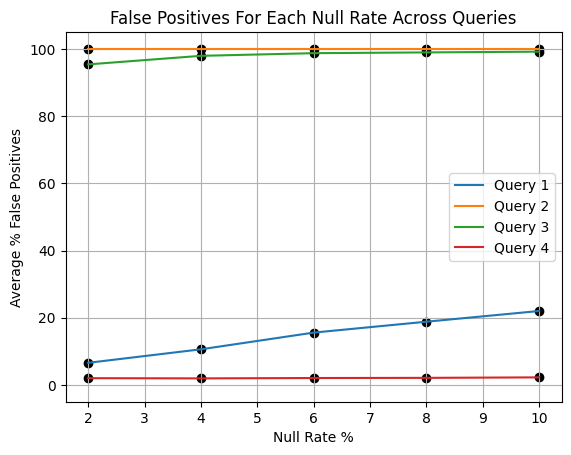

In [27]:
null_rates_mod = [int(rate*100) for rate in null_rates]
# Read CSV file into DataFrame
df = pd.read_csv(f'{results_dir}/fp_results.csv', header=None)  # Assuming CSV file has no header

# Plot each row as a separate line with different colors
for i, row in df.iterrows():
    row_mod = [(r*100) for r in row]
    plt.plot(null_rates_mod, row_mod, label=f'Query {i+1}', alpha=1)  # Plot lines with some transparency

# Scatter plot for each data point
for i, row in df.iterrows():
    row_mod = [(r*100) for r in row]
    plt.scatter(null_rates_mod, row_mod, color='black', alpha=1)  # Scatter plot for each data point

plt.title("False Positives For Each Null Rate Across Queries")
plt.xlabel("Null Rate %")
plt.ylabel("Average % False Positives")
plt.legend()
plt.grid(True)
plt.ylim(-5,105)
plt.savefig(f'{results_dir}/false_positives.png')
plt.show()

In [ ]:
sql_commands.close_db(mydb, mycursor)